In [1]:
import pandas as pd
import os

# ==========================================
# 1. 设置路径
# ==========================================
# 根据你的描述，notebook 在当前目录，数据在 OneDrive_1_2025-11-24/trade_data 下
base_path = './OneDrive_1_2025-11-24/trade_data/'

# 文件名定义
files_to_load = [
    'BACI_HS12_Y2016_V202001.csv',
    'BACI_HS12_Y2017_V202001.csv',
    'BACI_HS12_Y2018_V202001.csv'
]
country_file = 'country_codes_V202001.csv'
product_file = 'product_codes_HS12_V202001.csv'

# ==========================================
# 2. 读取并合并贸易数据
# ==========================================
df_list = []
print("开始读取年度贸易数据...")

for f in files_to_load:
    file_path = os.path.join(base_path, f)
    print(f"正在读取: {f}")
    # 指定 dtype 可以在读取时就防止一些类型错误，尤其是 k (产品代码)
    # 注意：BACI数据有时很大，如果不指定类型，pandas会自动推断
    temp_df = pd.read_csv(file_path)
    df_list.append(temp_df)

# 合并三年数据
df_trade = pd.concat(df_list, ignore_index=True)
print(f"合并完成，总行数: {len(df_trade)}")

# ==========================================
# 3. 关键字段标准化 (Data Cleaning)
# ==========================================
# [核心步骤] 处理 HS6 产品代码
# Excel 或 CSV 读取时，'010101' 可能会变成数字 '10101'，需要补回前面的0
# [cite_start]参考文档 Hint: Pad a leading zero to restore the 6-digit code [cite: 51, 52]
df_trade['k'] = df_trade['k'].astype(str).str.zfill(6)

# [核心步骤] 生成 HS2 简码
# [cite_start]参考文档 Q2 要求: Aggregate export values into broad two-digit product categories [cite: 26, 44]
df_trade['hs2'] = df_trade['k'].str[:2]

# ==========================================
# 4. 匹配国家和产品名称 (Mapping)
# ==========================================
print("正在加载元数据并进行匹配...")

# --- 4.1 匹配国家名称 ---
# 读取国家代码表
df_country = pd.read_csv(os.path.join(base_path, country_file), encoding='ISO-8859-1') 
# 注意：如果遇到编码报错，尝试 'utf-8' 或 'ISO-8859-1'
# BACI 的国家代码表通常包含 'country_code' (数字) 和 'country_name_full'
# 我们创建一个字典来映射： 124 -> "Canada"
country_map = dict(zip(df_country['country_code'], df_country['country_name_full']))

# 映射 Exporter (i) 和 Importer (j)
df_trade['exporter_name'] = df_trade['i'].map(country_map)
df_trade['importer_name'] = df_trade['j'].map(country_map)

# --- 4.2 匹配产品描述 ---
# 读取产品代码表
df_product = pd.read_csv(os.path.join(base_path, product_file), encoding='ISO-8859-1')
# 同样确保产品表里的代码也是6位字符串，防止匹配不上
df_product['code'] = df_product['code'].astype(str).str.zfill(6)
product_map = dict(zip(df_product['code'], df_product['description']))

# 映射产品描述
df_trade['product_desc'] = df_trade['k'].map(product_map)

# ==========================================
# 5. 检查与保存
# ==========================================
# 简单检查一下是否有空值（比如有国家代码没匹配到名字）
missing_exporters = df_trade['exporter_name'].isnull().sum()
print(f"未匹配到出口国名称的行数: {missing_exporters}")

# 保存清洗好的数据
output_filename = 'cleaned_trade_data_2016_2018.csv'
df_trade.to_csv(output_filename, index=False)
print(f"数据清洗完成！已保存为: {output_filename}")
print("包含列:", df_trade.columns.tolist())

# 显示前几行看看效果¥
print(df_trade.head())

开始读取年度贸易数据...
正在读取: BACI_HS12_Y2016_V202001.csv
正在读取: BACI_HS12_Y2017_V202001.csv
正在读取: BACI_HS12_Y2018_V202001.csv
合并完成，总行数: 24025656
正在加载元数据并进行匹配...
未匹配到出口国名称的行数: 0
数据清洗完成！已保存为: cleaned_trade_data_2016_2018.csv
包含列: ['t', 'i', 'j', 'k', 'v', 'q', 'hs2', 'exporter_name', 'importer_name', 'product_desc']
      t  i   j       k           v        q hs2 exporter_name importer_name  \
0  2016  4  12  080132   26.313000    3.000  08   Afghanistan       Algeria   
1  2016  4  12  130190    1.507000    0.585  13   Afghanistan       Algeria   
2  2016  4  12  370239    1.121000    0.003  37   Afghanistan       Algeria   
3  2016  4  12  970600   17.236000    0.019  97   Afghanistan       Algeria   
4  2016  4  24  480300  315.120626  186.534  48   Afghanistan        Angola   

                                        product_desc  
0  Nuts, edible: cashew nuts, fresh or dried, she...  
1  Natural gums, resins, gum-resins and oleoresin...  
2  Photographic film: in rolls, (other than with ...  

In [15]:
df_trade = pd.read_csv('cleaned_trade_data_2016_2018.csv')

# ==========================================
# 1. 最终名称清洗 (User Approved Version)
# ==========================================
name_corrections = {
    "Other Asia, not elsewhere specified": "Other Asia",
    "USA, Puerto Rico and US Virgin Islands": "USA",
    "China, Hong Kong Special Administrative Region": "Hong Kong",
    "China, Macao Special Administrative Region": "Macau",
    "Republic of Korea": "South Korea",
    "Democratic People's Republic of Korea": "North Korea",
    "Viet Nam": "Vietnam",
    "Lao People's Dem. Rep.": "Laos",
    "Russian Federation": "Russia",
    "The Former Yugoslav Republic of Macedonia": "Macedonia",
    "Republic of Moldova": "Moldova",
    "Plurinational State of Bolivia": "Bolivia",
    "United Republic of Tanzania": "Tanzania",
    "Democratic Republic of the Congo": "DR Congo",
    "Southern African Customs Union": "South Africa (SACU)"
}

print("正在执行最终名称替换...")
df_trade['exporter_name'] = df_trade['exporter_name'].replace(name_corrections)
df_trade['importer_name'] = df_trade['importer_name'].replace(name_corrections)

print("✅ 文件已覆盖保存！")

# ==========================================
# 3. 最终结果验证
# ==========================================
# 重新读取前几行
df_preview = pd.read_csv(output_filename, nrows=5)
print("\n=== 文件预览 (前5行) ===")
print(df_preview[['t', 'exporter_name', 'importer_name', 'v', 'hs2']])

print("\n=== 检查 'Other Asia' ===")
# 检查是否还有旧名字
old_name_exists = "Other Asia, not elsewhere specified" in df_trade['exporter_name'].values
new_name_exists = "Other Asia" in df_trade['exporter_name'].values
print(f"旧名字是否存在: {old_name_exists}")
print(f"新名字 'Other Asia' 是否存在: {new_name_exists}")

正在执行最终名称替换...
✅ 文件已覆盖保存！

=== 文件预览 (前5行) ===
      t exporter_name importer_name           v  hs2
0  2016   Afghanistan       Algeria   26.313000    8
1  2016   Afghanistan       Algeria    1.507000   13
2  2016   Afghanistan       Algeria    1.121000   37
3  2016   Afghanistan       Algeria   17.236000   97
4  2016   Afghanistan        Angola  315.120626   48

=== 检查 'Other Asia' ===
旧名字是否存在: False
新名字 'Other Asia' 是否存在: True


In [9]:
df = pd.read_csv('cleaned_trade_data_2016_2018.csv')

#Part1 Q1
# 1. 提取所有唯一的双边贸易关系 (exporter, importer)
# 注意：这里我们只关心是否有贸易关系，不关心产品和年份
df_relations = df[['i', 'j']].drop_duplicates()

# 2. 统计每个国家（作为出口国或进口国）的总贸易伙伴数量

# 2.1. 统计作为出口国的伙伴数量
# 关系：(exporter, importer)
exporter_counts = df_relations.groupby('i')['j'].nunique().reset_index()
exporter_counts.columns = ['country_code', 'exporter_partner_count']

# 2.2. 统计作为进口国的伙伴数量
# 关系：(importer, exporter)
importer_counts = df_relations.groupby('j')['i'].nunique().reset_index()
importer_counts.columns = ['country_code', 'importer_partner_count']

# 3. 合并统计结果并计算总伙伴数
# 确保所有国家都被包含
all_countries = pd.merge(exporter_counts, importer_counts, on='country_code', how='outer').fillna(0)

# 计算总的唯一伙伴数
# 注意：如果 A -> B， B -> A，则 A 的伙伴数是 1 (B)， B 的伙伴数是 1 (A)。
# 但我们上面统计的是单向的。为了获取真正的“唯一伙伴数”，
# 我们应该先创建一个包含所有国家代码的列表，然后去重计算。

# 重新定义：构建一个包含所有国家代码和其伙伴代码的列表
partner_list = []
for index, row in df_relations.iterrows():
    # Exporter i 的伙伴是 j
    partner_list.append({'country_code': row['i'], 'partner_code': row['j']})
    # Importer j 的伙伴是 i
    partner_list.append({'country_code': row['j'], 'partner_code': row['i']})

df_partners = pd.DataFrame(partner_list)

# 筛选掉自己和自己的贸易 (理论上 BACI 中 i != j)
df_partners = df_partners[df_partners['country_code'] != df_partners['partner_code']]

# 计算每个国家的唯一贸易伙伴数量
final_counts = df_partners.groupby('country_code')['partner_code'].nunique().reset_index()
final_counts.columns = ['country_code', 'total_partners']

# 4. 匹配国家名称
# 我们需要重新加载 country_map 或使用之前创建的名称列
# 这里使用之前清洗步骤中用到的 iso_dict 来映射
df_country_codes = pd.read_csv(os.path.join(base_path, country_file), encoding='ISO-8859-1')
iso_dict = dict(zip(df_country_codes['country_code'], df_country_codes['country_name_full']))
final_counts['country_name'] = final_counts['country_code'].map(iso_dict)

# 5. 排序并显示结果

# --- Top 10 贸易伙伴最多的国家 ---
top_10 = final_counts.sort_values(by='total_partners', ascending=False).head(10)
print("\n=== Top 10 贸易伙伴最多的国家 ===")
print(top_10[['country_name', 'total_partners']])

# --- Bottom 10 贸易伙伴最少的国家 ---
bottom_10 = final_counts.sort_values(by='total_partners', ascending=True).head(10)
print("\n=== Bottom 10 贸易伙伴最少的国家 ===")
print(bottom_10[['country_name', 'total_partners']])


=== Top 10 贸易伙伴最多的国家 ===
           country_name  total_partners
74              Germany             220
95                Italy             220
196            Thailand             220
66       France, Monaco             220
188               Spain             220
132         Netherlands             220
158              Poland             220
21               Brazil             219
16   Belgium-Luxembourg             219
211      United Kingdom             219

=== Bottom 10 贸易伙伴最少的国家 ===
                           country_name  total_partners
133                Netherlands Antilles               1
137   Bonaire, Saint Eustatius and Saba              36
171           Saint Pierre and Miquelon              43
166                    Saint Barthélemy              46
136          Saint Maarten (Dutch part)              50
41                    Christmas Islands              50
145                     Norfolk Islands              51
68   French South Antarctic Territories              52
2

In [10]:
#Part1 Q2
# ==========================================
# 1. 描述整个数据集的贸易总量 [cite: 35]
# ==========================================
total_trade_value = df['v'].sum()
print(f"整个数据集的总贸易价值 (Total Trade Value): ${total_trade_value:,.2f} (千美元)")

# ==========================================
# 2. 定义分析函数：获取某国的 Top 10 贸易伙伴
# ==========================================
def get_top_partners(df, country_name):
    # 筛选出与该国有关的所有贸易记录
    # 逻辑：无论是作为出口国还是进口国
    df_country = df[(df['exporter_name'] == country_name) | (df['importer_name'] == country_name)].copy()
    
    if df_country.empty:
        print(f"警告：未找到名称为 '{country_name}' 的国家，请检查名称拼写。")
        return None

    # 创建一个 'partner' 列
    # 如果出口国是 target，伙伴就是 importer；否则伙伴是 exporter
    df_country['partner'] = df_country.apply(
        lambda x: x['importer_name'] if x['exporter_name'] == country_name else x['exporter_name'], 
        axis=1
    )
    
    # 按伙伴分组汇总贸易额 (v)
    partner_trade = df_country.groupby('partner')['v'].sum().reset_index()
    
    # 排序并取前 10
    top_10 = partner_trade.sort_values(by='v', ascending=False).head(10)
    top_10.columns = ['Partner Country', 'Total Trade Value']
    
    return top_10

# ==========================================
# 3. 执行分析：中国和美国 [cite: 36]
# ==========================================
# 先确认一下名字，你可以用 df['exporter_name'].unique() 查看，或者试探性运行
# 常见名称：'China', 'USA', 'United States'
target_china = 'China'
target_usa = 'USA' # 如果报错，试着改成 'United States'

print(f"\n--- {target_china} 的 Top 10 贸易伙伴 ---")
top_china = get_top_partners(df, target_china)
print(top_china)

print(f"\n--- {target_usa} 的 Top 10 贸易伙伴 ---")
top_usa = get_top_partners(df, target_usa)
print(top_usa)

# ==========================================
# 4. 中国的 Top 5 贸易流 (Highest-value China-partner trade flows) 
# ==========================================
# 这里的 "Trade Flow" 通常指：特定年份(t) + 特定方向(i->j) 的总贸易额
# 先聚合到 (t, i, j) 层面
df_flows = df.groupby(['t', 'exporter_name', 'importer_name'])['v'].sum().reset_index()

# 筛选涉及中国的流
china_flows = df_flows[
    (df_flows['exporter_name'] == target_china) | 
    (df_flows['importer_name'] == target_china)
]

# 排序取前 5
top_5_china_flows = china_flows.sort_values(by='v', ascending=False).head(5)

print(f"\n--- 样本期内最高的 5 个涉及 {target_china} 的贸易流 ---")
print(top_5_china_flows)

整个数据集的总贸易价值 (Total Trade Value): $50,225,134,802.27 (千美元)

--- China 的 Top 10 贸易伙伴 ---
    Partner Country  Total Trade Value
192             USA       1.802824e+09
93            Japan       8.706484e+08
82        Hong Kong       8.200636e+08
170     South Korea       7.294378e+08
70          Germany       6.054614e+08
137      Other Asia       4.174164e+08
9         Australia       3.988786e+08
201         Vietnam       3.032261e+08
149          Russia       2.628019e+08
196  United Kingdom       2.461285e+08

--- USA 的 Top 10 贸易伙伴 ---
    Partner Country  Total Trade Value
40            China       1.802824e+09
123          Mexico       1.530376e+09
35           Canada       1.368959e+09
99            Japan       5.976576e+08
76          Germany       5.433130e+08
179     South Korea       3.625587e+08
205  United Kingdom       3.210049e+08
70   France, Monaco       2.221244e+08
91            India       2.198154e+08
144      Other Asia       2.089931e+08

--- 样本期内最高的 5 个涉及 China 的贸易

In [2]:
#Part1 Q3
# ==========================================
# 任务 A: 中国、日本、美国的 Top 10 出口产品 (按 Value)
# ==========================================
target_countries = ['China', 'Japan', 'USA']

print("=== 各国 Top 10 出口产品 (按价值 Value) ===")

for country in target_countries:
    # 1. 筛选该国作为出口商的数据
    country_data = df[df['exporter_name'] == country]
    
    # 2. 按产品描述分组，汇总价值
    # 我们同时保留 'k' (HS6代码) 以便查阅
    top_products = country_data.groupby(['k', 'product_desc'])['v'].sum().reset_index()
    
    # 3. 排序并取前 10
    top_10 = top_products.sort_values(by='v', ascending=False).head(10)
    
    print(f"\n--- {country} Top 10 Exports ---")
    # 格式化输出：排名、代码、金额、名称
    for idx, row in top_10.reset_index().iterrows():
        print(f"{idx+1}. [HS: {row['k']}] ${row['v']:,.0f} (千美元)")
        print(f"   {row['product_desc']}")

# ==========================================
# 任务 B: 全球 Top 10 热门商品 (按 Value 和 Quantity)
# ==========================================
print("\n\n=== 全球 Top 10 热门交易商品 (按 Value & Quantity) ===")

# 按产品汇总整个数据集
global_products = df.groupby(['k', 'product_desc'])[['v', 'q']].sum().reset_index()

# --- 1. 按价值 (Value) 排序 ---
top_10_value = global_products.sort_values(by='v', ascending=False).head(10)
print("\n[按 价值 Value 排序 - Top 10]")
for idx, row in top_10_value.reset_index().iterrows():
    print(f"{idx+1}. ${row['v']:,.0f} (千美元) - {row['product_desc']}")

# --- 2. 按数量 (Quantity) 排序 ---
# 注意：数量单位通常是公吨 (Metric Tons)，但不同商品单位可能不同（需参考BACI文档，通常主要是重量）
top_10_qty = global_products.sort_values(by='q', ascending=False).head(10)
print("\n[按 数量 Quantity 排序 - Top 10]")
for idx, row in top_10_qty.reset_index().iterrows():
    print(f"{idx+1}. {row['q']:,.0f} (单位) - {row['product_desc']}")

=== 各国 Top 10 出口产品 (按价值 Value) ===

--- China Top 10 Exports ---
1. [HS: 851712] $526,086,638 (千美元)
   Telephones for cellular networks or for other wireless networks
2. [HS: 847130] $313,684,603 (千美元)
   Automatic data processing machines: portable, weighing not more than 10kg, consisting of at least a central processing unit, a keyboard and a display
3. [HS: 851770] $167,651,740 (千美元)
   Telephone sets and other apparatus for the transmission or reception of voice, images or other data, via a wired or wireless network: parts
4. [HS: 851762] $164,660,423 (千美元)
   Communication apparatus (excluding telephone sets or base stations): machines for the reception, conversion and transmission or regeneration of voice, images or other data, including switching and routing apparatus
5. [HS: 847330] $149,152,499 (千美元)
   Machinery: parts and accessories of the machines of heading no. 8471 (other than covers, carrying cases and the like)
6. [HS: 950300] $91,615,032 (千美元)
   Tricycles, scooters, 

正在读取 Shapefile...
找到中国质心，匹配到的名称为: China
正在读取贸易数据...
合并完成: 共有 160 个国家成功匹配到了距离数据。


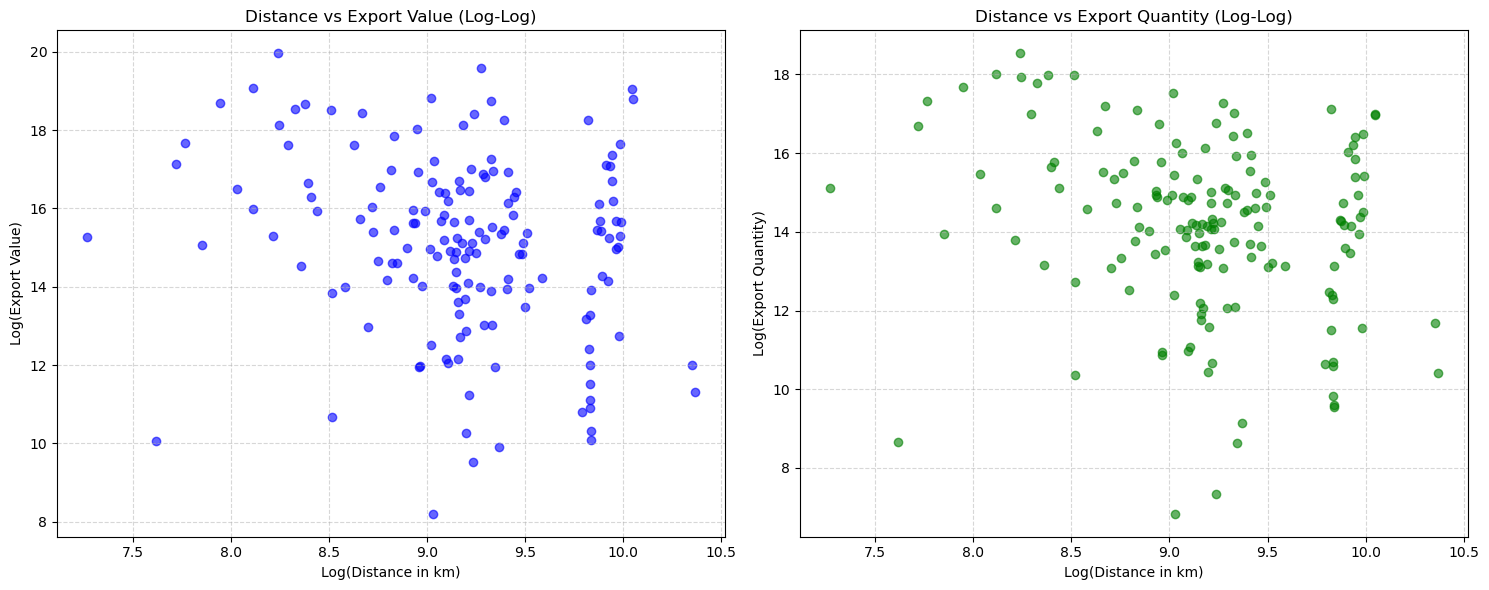


[相关性分析]
Log(距离) 与 Log(出口额 Value) 的相关系数: -0.2170
Log(距离) 与 Log(出口量 Quantity) 的相关系数: -0.2388


In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ==========================================
# 1. 读取 Shapefile 并处理地理数据
# ==========================================
# 设置 shapefile 路径 (保持你之前的路径不变)
shp_path = './OneDrive_1_2025-11-24/countries_shapefile/cn_primary_countries.shp'

print("正在读取 Shapefile...")
gdf = gpd.read_file(shp_path)

# --- 坐标系转换与距离计算 ---
# 转换为 EPSG:3857 (Web Mercator) 以计算米
gdf_proj = gdf.to_crs(epsg=3857)

# 计算每个国家的质心
gdf_proj['centroid'] = gdf_proj.geometry.centroid

# [修正点]：使用 'name' 列来查找 China
china_row = gdf_proj[gdf_proj['name'].str.contains('China', case=False, na=False)]

if len(china_row) == 0:
    print("错误：在 Shapefile 的 'name' 列中没找到 'China'。")
    print("前10个名字:", gdf_proj['name'].head(10).values)
else:
    # 获取中国质心
    china_centroid = china_row.iloc[0]['centroid']
    print(f"找到中国质心，匹配到的名称为: {china_row.iloc[0]['name']}")

    # 计算距离 (单位: 千米)
    gdf_proj['distance_km'] = gdf_proj['centroid'].distance(china_centroid) / 1000.0

    # [修正点]：提取 'name' 列和距离
    dist_df = gdf_proj[['name', 'distance_km']].copy()
    
    # 将 'name' 重命名为 'importer_name' 以便和贸易数据合并
    dist_df = dist_df.rename(columns={'name': 'importer_name'})
    
    # 名字清洗 (Shapefile 的名字 -> 贸易数据的名字)
    # 根据经验，Shapefile 里的名字通常比较正式，需要映射回我们清洗过的简称
    dist_df['importer_name'] = dist_df['importer_name'].replace({
        "United States of America": "USA", # Shapefile 里常叫这个
        "United States": "USA",
        "Korea, Republic of": "South Korea",
        "South Korea": "South Korea",
        "Russian Federation": "Russia",
        "Russia": "Russia",
        "United Kingdom": "UK",
        "Vietnam": "Vietnam"
    })

# ==========================================
# 2. 准备贸易数据 (China Exports)
# ==========================================
print("正在读取贸易数据...")
df_trade = pd.read_csv('cleaned_trade_data_2016_2018.csv')

# 筛选：出口国是 China
df_china_export = df_trade[df_trade['exporter_name'] == 'China'].copy()

# 按进口国汇总 Value 和 Quantity
df_china_agg = df_china_export.groupby('importer_name')[['v', 'q']].sum().reset_index()

# ==========================================
# 3. 合并数据
# ==========================================
# 将距离数据合进来
merged_df = pd.merge(df_china_agg, dist_df, on='importer_name', how='inner')

print(f"合并完成: 共有 {len(merged_df)} 个国家成功匹配到了距离数据。")

# 检查一下如果匹配得太少，打印出来看看是哪些匹配上了
if len(merged_df) < 100:
    print("警告：匹配到的国家数量较少，建议检查 Shapefile 中的国家名称格式。")
    print("Shapefile 中的部分名字:", dist_df['importer_name'].head(10).values)

# ==========================================
# 4. 绘图 (Log-Log Scatterplot)
# ==========================================
# 数据取对数
merged_df['log_dist'] = np.log1p(merged_df['distance_km'])
merged_df['log_value'] = np.log1p(merged_df['v'])
merged_df['log_quantity'] = np.log1p(merged_df['q'])

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 图 1: 距离 vs 贸易额 (Value)
axes[0].scatter(merged_df['log_dist'], merged_df['log_value'], alpha=0.6, color='blue')
axes[0].set_title('Distance vs Export Value (Log-Log)')
axes[0].set_xlabel('Log(Distance in km)')
axes[0].set_ylabel('Log(Export Value)')
axes[0].grid(True, linestyle='--', alpha=0.5)

# 图 2: 距离 vs 贸易量 (Quantity)
axes[1].scatter(merged_df['log_dist'], merged_df['log_quantity'], alpha=0.6, color='green')
axes[1].set_title('Distance vs Export Quantity (Log-Log)')
axes[1].set_xlabel('Log(Distance in km)')
axes[1].set_ylabel('Log(Export Quantity)')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 相关性系数
print("\n[相关性分析]")
print(f"Log(距离) 与 Log(出口额 Value) 的相关系数: {merged_df[['log_dist', 'log_value']].corr().iloc[0,1]:.4f}")
print(f"Log(距离) 与 Log(出口量 Quantity) 的相关系数: {merged_df[['log_dist', 'log_quantity']].corr().iloc[0,1]:.4f}")